In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from solution import RNN_network, SmilesDataset, create_loader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
tasks = ["P23458","O60674","P52333","P29597"]
n_tasks = len(tasks)
tokens = pickle.load(open('tokens.pkl', 'rb'))

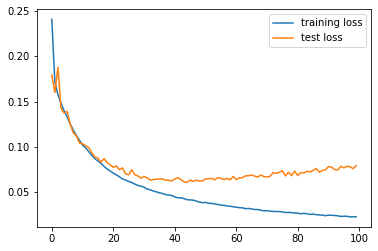

In [3]:
train_losses, test_losses = pickle.load(open('lstm_training_metrics.pkl', 'rb'))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [4]:
model = RNN_network(n_layers=2,
                    layer="GRU", 
                    bidirectional=False,
                    embedding_dim=256,
                    encoder_dim=256,
                    num_embeddings=41,
                    padding_idx=40,
                    dropout=0.8,
                    mlp_dropout=0.8,
                    mlp_hidden_size=256
                )
model = model.to(device)
model.load_state_dict(torch.load('lstm/checkpoint/epoch_35', map_location=device))

<All keys matched successfully>

In [5]:
df = pd.read_csv('data/test_answer.csv')
# df.head()

test_dataset = SmilesDataset('data/test_answer.csv', smiles_col='StdSMILES', target_cols=tasks, tokens=tokens)
# test_loader = create_loader(test_dataset, batch_size=

predictions, targets = [], []
for data in test_dataset:
    tokens, length, label = data['tokenized_smiles'], data['length'], data['labels']
    out = model.forward((torch.unsqueeze(torch.tensor(tokens, dtype=torch.long, device=device), dim=0), torch.unsqueeze(torch.tensor(length, dtype=torch.long, device=device), dim=0)), pack=False)
    # print(out.shape)
    prediction = np.argmax(torch.squeeze(out, dim=0).detach().cpu().numpy(), axis=0)
    # prediction = np.argmin(torch.squeeze(out, dim=0).detach().cpu().numpy(), axis=0)

    predictions.append(prediction)
    targets.append(label)

# predictions = np.concatenate(predictions, axis=0)
# targets = np.concatenate(targets, axis=0)

In [6]:
def multitask_auc(ground_truth, predicted, return_mean=True):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    import torch
    ground_truth = np.array(ground_truth)
    predicted = np.array(predicted)
    n_tasks = ground_truth.shape[1]
    auc = []
    for i in range(n_tasks):
        ind = np.where(ground_truth[:, i] != 999)[0]
        auc.append(roc_auc_score(ground_truth[ind, i], predicted[ind, i]))
    #if torch.distributed.get_rank() == 0:
    #    print(auc)
    if return_mean:
        return np.mean(auc)
    else:
        return auc
    
auc = multitask_auc(targets, predictions)
print(auc)

0.7810560007361231


In [7]:
df.head()

,StdSMILES,P23458,O60674,P52333,P29597
0,Cc1ccccc1-n1nccc1NC(=O)c1cnn2ccc(N)nc12,0.0,0.0,0.0,0.0
1,C[C@@H]1CCN(S(=O)(=O)c2cccc(C(F)(F)F)c2)C[C@@H...,1.0,1.0,1.0,1.0
2,O=C(Nc1ccc2cc1CCc1cccc(c1)Nc1ncc(Cl)c(n1)N2)N[...,1.0,1.0,1.0,1.0
3,COc1cc(CNc2ccn3ncc(C(=O)NC4CCCCC4)c3n2)cc(OC)c1,0.0,0.0,0.0,0.0
4,Cc1cc2ncc(-c3ccccc3)nc2cc1C,0.0,0.0,0.0,0.0


In [8]:
predictions = np.array(predictions)

In [9]:
df_prediction = pd.DataFrame({'StdSMILES': list(df['StdSMILES']), 'P23458':predictions[:, 0],
                              'O60674': predictions[:, 1],
                              'P52333': predictions[:, 2],
                              'P29597': predictions[:, 3]})

In [10]:
df_prediction.head()

,StdSMILES,P23458,O60674,P52333,P29597
0,Cc1ccccc1-n1nccc1NC(=O)c1cnn2ccc(N)nc12,0,0,0,0
1,C[C@@H]1CCN(S(=O)(=O)c2cccc(C(F)(F)F)c2)C[C@@H...,1,1,1,1
2,O=C(Nc1ccc2cc1CCc1cccc(c1)Nc1ncc(Cl)c(n1)N2)N[...,1,1,1,1
3,COc1cc(CNc2ccn3ncc(C(=O)NC4CCCCC4)c3n2)cc(OC)c1,0,1,0,1
4,Cc1cc2ncc(-c3ccccc3)nc2cc1C,0,0,0,0


In [11]:
df_prediction.to_csv('lstm_submission.csv', index=False)